# 2D DC Resistivity Sensitivity analysis

```{admonition} Introductory notebook
:class: hint
This tutorial teaches basic functionality within SimPEG and is a good entry point for new users.
```

```{admonition} Light-weight notebook
:class: hint
This tutorial requires minimal computational resources and can be executed quickly in the background while other computer processes are running.
```

**Author:** Williams Lima

</br>

**Keywords:** DC Resistivity inversion, sensitivity matrix.

</br>

**Summary:**
The sensitivity matrix is a very important, and frequently used, tool to consider when designing a DC resistivity survey. It can give us qualitative and, to some extent, quantitave information about the capability of estimating the distribution of electrical conductivities underground using a particular experimental setup and geological environment. In this tutorial we'll use SimPEG functionalities to look at the sensitivity matrix for the DC resistivity inverse problem. We will analyse the sensitivity patterns for a few commonly used electrode arrays using a homogeneous conductivity model and also look at a real data case from a mineral exploration scenario. Enjoy!

</br>

**Learning Objectives:**

- How to get the sensitivity matrix for a DC resistivits simulation by using utility functions in SimPEG.
- Exploring the different sensitivity patterns for a number of common electrode arrays.
- How to plot information contained in the sensitivity matrix.
- Look at the sensitivity matrix for a real data set.

</br>

## Import modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to DC resistivity is imported from [SimPEG.electromagnetics.static.resistivity](myst:SimPEG#SimPEG.electromagnetics.static.resistivity).

We also import some useful utility functions from [SimPEG.utils](myst:SimPEG#SimPEG.utils). To simulate DC resistivity data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we used the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [47]:
# SimPEG functionality
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG import maps

# discretize functionality
from discretize import TreeMesh
from discretize.utils import refine_tree_xyz

# Common Python functionality
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

## Homogeneous half space

### Define surveys
There are many different possible combinations of current and potential electrodes locations that could be used to create a DC resistivity survey. Maybe some of those combinations would be better than others for a particular case under specific constraints such as cost, physical constraints, time and sensitivity to a particular target at depth. The sensitivity analysis, that we are going to perform in this tutorial, will help us with the task of assessing the performance of a given electrode array with respect to its sensitivity to conductivity anomalies around a particular target region in the subsurface. For more information about DC resistivity modeling in SimPEG check out the tutorial [2.5D DC Resistivity Simulation](05-dcr/fwd_dcr_2d).

In the figure below, we can see a few of the most common array configurations used in the industry and academic works.

```{figure}https://gpg.geosci.xyz/_images/figure6.gif
:width: 350px
:align: center

DC resistivity arrays ([image source](https://gpg.geosci.xyz/_images/figure6.gif))
```

**Two simple surveys in a homogeneous medium**

Our first step is to create two simple surveys, Wenner alpha and Wenner beta. Each of theses surveys will contain one pair of current electrodes and one pair of potential electrodes only. The extension to any number of current/potential electrodes is straightforward and will be left as an exercise.



In [15]:
# Define survey line parameters for Wenner surveys
data_type = "volt"
src_list = []

# Wenner alpha
C_wenner_alpha = np.array([[-15.0, 0.0], [15.0, 0.0]])
P_wenner_alpha = np.array([[-5.0, 0.0], [5.0, 0.0]])

rx_wenner_alpha = dc.receivers.Dipole(locations_m=P_wenner_alpha[0], locations_n=P_wenner_alpha[1], data_type=data_type) 
rx_list_wenner_alpha = [rx_wenner_alpha]

src_list.append(dc.sources.Dipole(location_a=C_wenner_alpha[0], location_b=C_wenner_alpha[1], receiver_list=rx_list_wenner_alpha))

# Dipole-Dipole
C_dipole_dipole = np.array([[-15.0, 0.0], [-5.0, 0.0]])
P_dipole_dipole = np.array([[5.0, 0.0], [15.0, 0.0]])

rx_dipole_dipole = dc.receivers.Dipole(locations_m=P_dipole_dipole[0], locations_n=P_dipole_dipole[1], data_type=data_type) 
rx_list_dipole_dipole = [rx_dipole_dipole]

src_list.append(dc.sources.Dipole(location_a=C_dipole_dipole[0], location_b=C_dipole_dipole[1], receiver_list=rx_list_dipole_dipole))

survey = dc.Survey(source_list=src_list)

### Create mesh

In [16]:
dh = 0.25  # base cell width
dom_width_x = 300.0  # domain width x
dom_width_z = 200.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh with top at z = 0 m.
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN")

# Refine core mesh region
mesh.refine_box([-50,-50],[50,0], levels=-1, finalize=False)

mesh.finalize()

### Define the conductivity model

In [17]:
background_resistivity = 50 # Ohm.m
background_conductivity = 1/background_resistivity
nC = mesh.nC
conductivity_model = background_conductivity * np.ones(nC)

conductivity_map = maps.IdentityMap()

In [18]:
# DC simulation for a conductivity model
simulation_con = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map
)

### Plot sensitivity

**Get the sensitivity matrix**

In [49]:
J = simulation_con.getJ(conductivity_model).copy()
J_wenner_alpha = J[0,:]/np.max(abs(J[0,:]))
J_dipole_dipole = J[1,:]/np.max(abs(J[1,:]))

**Make plots**

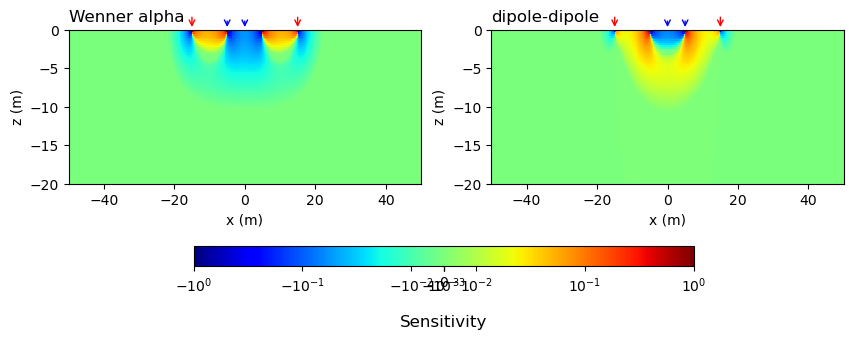

In [46]:
fig, axs = plt.subplots(1,2, figsize=(10,2))
plt.jet()

norm = mpl.colors.SymLogNorm(
    linthresh=0.005, linscale=1e-4,
    vmin=-1.0, vmax=1.0, base=10)

Js = np.c_[J_wenner_alpha, J_dipole_dipole] 
C_locs = np.r_[C_wenner_alpha, C_dipole_dipole]
P_locs = np.r_[P_wenner_alpha, P_dipole_dipole]

i = 0
for ax in axs:    
    mesh.plot_image(
        Js[:,i],
        ax=ax,
        grid=False,
        pcolor_opts={"norm": norm}
    )
    
    xmin = -50; xmax = 50
    zmin = -20; zmax = 0
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(zmin, zmax)
    ax.set_title(plt_titles[i], loc="left")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")

    xc = (C_locs[i,0] - xmin)/(xmax - xmin)
    ax.annotate('', xy=(xc, 1), xycoords='axes fraction', xytext=(xc, 1.1), 
            arrowprops=dict(arrowstyle="->", color='r'))
    xc = (C_locs[i+1,0] - xmin)/(xmax - xmin)
    ax.annotate('', xy=(xc, 1), xycoords='axes fraction', xytext=(xc, 1.1), 
            arrowprops=dict(arrowstyle="->", color='r'))
    xc = (P_locs[i,0] - xmin)/(xmax - xmin)
    ax.annotate('', xy=(xc, 1), xycoords='axes fraction', xytext=(xc, 1.075), 
            arrowprops=dict(arrowstyle="->", color='b'))
    xc = (P_locs[i+1,1] - xmin)/(xmax - xmin)
    ax.annotate('', xy=(xc, 1), xycoords='axes fraction', xytext=(xc, 1.075), 
            arrowprops=dict(arrowstyle="->", color='b'))

    i = i + 1

ax2 = fig.add_axes([0.25, -0.3, 0.5, 0.1])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="horizontal"
)
cbar.set_label("Sensitivity", rotation=0, labelpad=15, size=12)

## Real data example

### The Century Deposit DC resistivity inversion

## Conclusions

In this tutorial we used the resources avaiable in SimPEG for computing and ploting the sensitivity matrix. We used the DC resistivity problem as a motivation example and analysed the sensitivity patterns for a homogeneous half space using two different survey layouts. We also applied this technique for a DC resistivity real data inversion scenario. This kind of analysis can help us decide upon the most appropriate electrode array to use for a particular exploration project. It is also a valuable tool to have in our toolbox for performing the assessment of the solutions obtained after the application of some inversion algorithm as illustrated by the real case example.

## Acknowledgements

## References